# Exploartion

The City of Stockholm has asked me to examine how seasonal weather affects cycling activity across its network. Using cycling counter data from 2018–2024, I will compare cyclist volumes between the cold (October–March) and warm (April–September) seasons, and identify routes that stay busy year-round.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
import pytz
from astral import LocationInfo
from astral.sun import sun
from scipy import stats

## Data Loading and Cleaning

In [2]:


# Read the DST CSV (utf-8, comma-delimited)
df_dst = pd.read_csv('stockholm_dst_end_2015_2025.csv', encoding='utf-8')

# Read the cycling 15-min counts (ascii, semicolon-delimited)
df_cykel = pd.read_csv('td_cykel_15_min_2015-2024.csv', encoding='ascii', sep=';')

# correct for Swedish CSV
df_platser = pd.read_csv('platser_cykel_2015-2024.csv', encoding='utf-8', sep=';')

In [3]:
print(df_dst.head(10))
print(df_cykel.head(10))
print(df_platser.head(10))

   Year       Date Day of Week  ISO Week  from      to
0  2015  25-Oct-15      Sunday        43  3:00   02:00
1  2016  30-Oct-16      Sunday        43  3:00   02:00
2  2017  29-Oct-17      Sunday        43  3:00   02:00
3  2018  28-Oct-18      Sunday        43  3:00   02:00
4  2019  27-Oct-19      Sunday        43  3:00   02:00
5  2020  25-Oct-20      Sunday        43  3:00   02:00
6  2021  31-Oct-21      Sunday        43  3:00   02:00
7  2022  30-Oct-22      Sunday        43  3:00   02:00
8  2023  29-Oct-23      Sunday        43  3:00   02:00
9  2024  27-Oct-24      Sunday        43  3:00   02:00
   matplats_id           tidsstampel  direction  antal  year  month  dag
0         6265  2015-01-01T01:45:00Z        NaN      1  2015      1    1
1         6265  2015-01-01T02:00:00Z        NaN      1  2015      1    1
2         6265  2015-01-01T02:45:00Z        NaN      1  2015      1    1
3         6265  2015-01-01T03:45:00Z        NaN      1  2015      1    1
4         6265  2015-01-01T06:

In [4]:
print(df_dst.dtypes)

Year            int64
Date           object
Day of Week    object
ISO Week        int64
from           object
to             object
dtype: object


In [5]:
print(df_cykel.dtypes)

matplats_id      int64
tidsstampel     object
direction      float64
antal            int64
year             int64
month            int64
dag              int64
dtype: object


In [6]:
print(df_platser.dtypes)

MätplatsID                    int64
Mätplatsnamn                 object
MätplatsBeskrivning          object
Sträcka                      object
RiktplatsA                   object
RiktplatsB                   object
R1                           object
R2                           object
koordinater.mätpunkter.R1    object
koordinater.mätpunkter.R2    object
dtype: object


In [7]:
# Drop all rows where year == 2024 because the 2024 data seem to be skewed
df_cykel = df_cykel[df_cykel['year'] != 2024].copy()

print("Remaining years in df_cykel:", sorted(df_cykel['year'].unique()))


Remaining years in df_cykel: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [8]:
# clean df_dst
# Parse the Date column from text like 25-Oct-15 to a proper datetime
df_dst['Date'] = pd.to_datetime(df_dst['Date'], format='%d-%b-%y', errors='coerce')

# Make Day of Week a category because it's a label
df_dst['Day of Week'] = df_dst['Day of Week'].astype('category')

# Create a helper column showing the time change (e.g. 3:00 -> 02:00)
df_dst['time_change'] = df_dst['from'].astype(str) + ' -> ' + df_dst['to'].astype(str)

# clean df_cykel
# Convert the timestamp string to a timezone-aware datetime in UTC
df_cykel['timestamp_utc'] = pd.to_datetime(df_cykel['tidsstampel'], utc=True, errors='coerce')

# Drop rows where timestamp parsing failed
df_cykel = df_cykel.dropna(subset=['timestamp_utc'])

# Convert UTC timestamps to Europe/Stockholm local time
df_cykel['timestamp_local'] = df_cykel['timestamp_utc'].dt.tz_convert('Europe/Stockholm')

# Make sure numeric fields are the right type
df_cykel['matplats_id'] = pd.to_numeric(df_cykel['matplats_id'], errors='coerce').astype('Int64')
df_cykel['antal'] = pd.to_numeric(df_cykel['antal'], errors='coerce').astype('Int64')
df_cykel['year'] = pd.to_numeric(df_cykel['year'], errors='coerce').astype('Int64')
df_cykel['month'] = pd.to_numeric(df_cykel['month'], errors='coerce').astype('Int64')
df_cykel['dag'] = pd.to_numeric(df_cykel['dag'], errors='coerce').astype('Int64')

# Add some useful time parts based on local time
df_cykel['date_local'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour_local'] = df_cykel['timestamp_local'].dt.hour
df_cykel['dow_local'] = df_cykel['timestamp_local'].dt.day_name()
df_cykel['week_local'] = df_cykel['timestamp_local'].dt.isocalendar().week.astype(int)

# Quick previews
print(df_dst.head(10))
print(df_dst.dtypes)
print(df_cykel.head(10))
print(df_cykel.dtypes)


   Year       Date Day of Week  ISO Week  from      to     time_change
0  2015 2015-10-25      Sunday        43  3:00   02:00  3:00 ->  02:00
1  2016 2016-10-30      Sunday        43  3:00   02:00  3:00 ->  02:00
2  2017 2017-10-29      Sunday        43  3:00   02:00  3:00 ->  02:00
3  2018 2018-10-28      Sunday        43  3:00   02:00  3:00 ->  02:00
4  2019 2019-10-27      Sunday        43  3:00   02:00  3:00 ->  02:00
5  2020 2020-10-25      Sunday        43  3:00   02:00  3:00 ->  02:00
6  2021 2021-10-31      Sunday        43  3:00   02:00  3:00 ->  02:00
7  2022 2022-10-30      Sunday        43  3:00   02:00  3:00 ->  02:00
8  2023 2023-10-29      Sunday        43  3:00   02:00  3:00 ->  02:00
9  2024 2024-10-27      Sunday        43  3:00   02:00  3:00 ->  02:00
Year                    int64
Date           datetime64[ns]
Day of Week          category
ISO Week                int64
from                   object
to                     object
time_change            object
dtype: ob

In [45]:
import pandas as pd

# I make sure the timestamp is in datetime format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows without a valid timestamp
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract the year
df_cykel['year'] = df_cykel['timestamp_local'].dt.year

# I group by year and count total cyclists and number of records
year_summary = (
    df_cykel.groupby('year', as_index=False)
    .agg(
        total_cyclists=('antal', 'sum'),     # total number of cyclists
        measurements=('antal', 'count')      # number of recorded measurements
    )
    .sort_values('year')
)

# I show the results
print(year_summary)


   year  total_cyclists  measurements
0  2015        22414480       1515736
1  2016        25482350       1667197
2  2017        20561080       1568258
3  2018        22264438       1665228
4  2019        21535441       1594219
5  2020        25206936       1836650
6  2021        19607880       1652899
7  2022        18832660       1476247
8  2023        14934680       1201508


In [43]:
df_cykel = df_cykel[df_cykel['timestamp_local'].dt.year.between(2015, 2023)]


In [44]:
# I check that it worked
print("Years now in df_cykel:", sorted(df_cykel['timestamp_local'].dt.year.unique()))

Years now in df_cykel: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## Exploratory Data Analysis (EDA)

### How do the cycling volumes behave over time?

#### How do the cycling volumes behave on a monthly level?

                           monthly_total
2023-01-31 00:00:00+01:00         761835
2023-02-28 00:00:00+01:00         777588
2023-03-31 00:00:00+02:00         772560
2023-04-30 00:00:00+02:00        1398223
2023-05-31 00:00:00+02:00        1954687


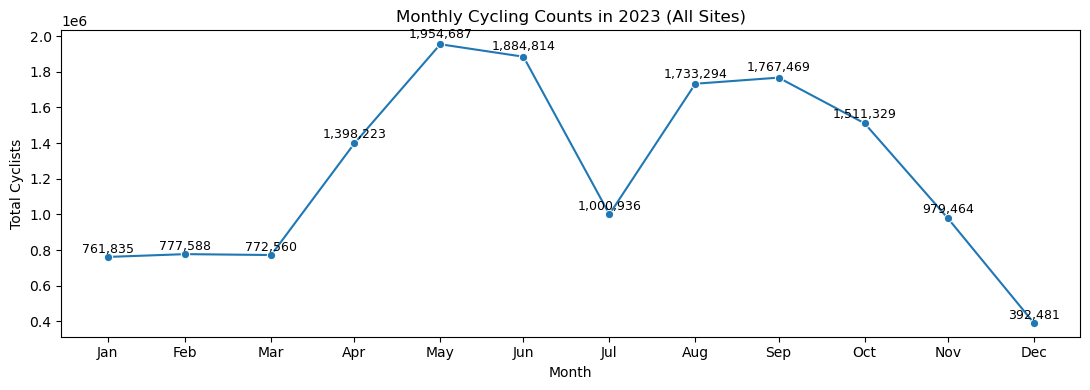

In [47]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I keep only the data from 2023
df_2023 = df_cykel[df_cykel['timestamp_local'].dt.year == 2023].copy()

# I set the timestamp as the index and sum up all cyclists per month
monthly_2023 = (
    df_2023
    .set_index('timestamp_local')
    .resample('ME')['antal']   # ME = month end
    .sum()
    .rename('monthly_total')
    .to_frame()
)

# I create a full list of all months in 2023
full_months_2023 = pd.date_range(
    start='2023-01-01',
    end='2023-12-31',
    freq='ME',
    tz='Europe/Stockholm'
)

# I make sure all months are included (even if some have no data)
monthly_2023_full = monthly_2023.tz_convert('Europe/Stockholm').reindex(full_months_2023)

# I check that the data looks right
print(monthly_2023_full.head())

# I create a line plot of total cyclists per month
plt.figure(figsize=(11, 4))
sns.lineplot(
    x=monthly_2023_full.index,
    y='monthly_total',
    data=monthly_2023_full,
    marker='o',
    color='#1f77b4'
)

# I add labels and title to make it clear
plt.title('Monthly Cycling Counts in 2023 (All Sites)')
plt.xlabel('Month')
plt.ylabel('Total Cyclists')

# I show month names (Jan, Feb, Mar, etc.) on the x-axis
plt.xticks(
    monthly_2023_full.index,
    [d.strftime('%b') for d in monthly_2023_full.index],
    rotation=0
)

# I add text labels above each data point
for x, y in zip(monthly_2023_full.index, monthly_2023_full['monthly_total']):
    if pd.notnull(y):
        plt.text(x, y * 1.01, format(int(y), ','), ha='center', va='bottom', fontsize=9)

# I make the layout tidy and show the plot
plt.tight_layout()
plt.show()


   year  month  monthly_total month_name
0  2015      1         545186        Jan
1  2015      2         588588        Feb
2  2015      3        1226221        Mar
3  2015      4        1817853        Apr
4  2015      5        2216580        May


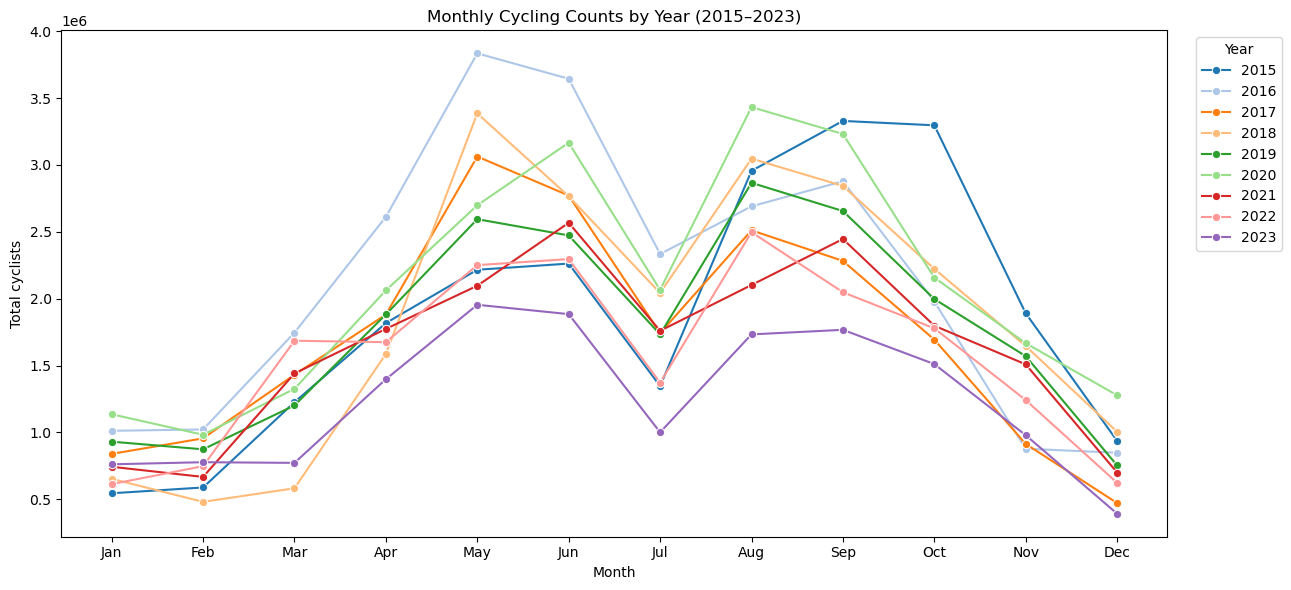

In [48]:
# I build monthly totals for each year (2015–2023) and plot one line per year

# I keep only data between 2015 and 2023
mask = (
    (df_cykel['timestamp_local'].dt.year >= 2015) &
    (df_cykel['timestamp_local'].dt.year <= 2023)
)
df_sub = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I extract year and month from the timestamp
df_sub['year'] = df_sub['timestamp_local'].dt.year
df_sub['month'] = df_sub['timestamp_local'].dt.month

# I group by year and month and sum the counts
monthly_by_year = (
    df_sub
    .groupby(['year', 'month'], as_index=False)['antal']
    .sum()
    .rename(columns={'antal': 'monthly_total'})
)

# I create readable month names
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_by_year['month_name'] = monthly_by_year['month'].map(month_map)

# I check the first few rows
print(monthly_by_year.head())

# I plot one line per year
plt.figure(figsize=(13, 6))
years_sorted = sorted(monthly_by_year['year'].unique())

sns.lineplot(
    data=monthly_by_year,
    x='month',
    y='monthly_total',
    hue='year',
    hue_order=years_sorted,
    marker='o',
    palette='tab20'
)

plt.title('Monthly Cycling Counts by Year (2015–2023)')
plt.xlabel('Month')
plt.ylabel('Total cyclists')
plt.xticks(
    ticks=range(1, 13),
    labels=[month_map[m] for m in range(1, 13)]
)
plt.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()


#### How do the cycling volumes behave during Daylight Saving Time?

In [49]:
# I filter the data to October and November 2023 in Stockholm time
start_date_2023 = pd.Timestamp('2023-10-01', tz='Europe/Stockholm')
end_date_2023 = pd.Timestamp('2023-11-30 23:59:59', tz='Europe/Stockholm')

mask_on_2023 = (
    (df_cykel['timestamp_local'] >= start_date_2023) &
    (df_cykel['timestamp_local'] <= end_date_2023)
)

df_on_2023 = df_cykel.loc[mask_on_2023, ['timestamp_local', 'antal']].copy()

# I calculate the total number of cyclists per day
daily_on_2023 = (
    df_on_2023
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I create a date label with the weekday in Stockholm time
_daily_local_naive = (
    daily_on_2023['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.tz_localize(None)
)
daily_on_2023['date_label'] = _daily_local_naive.dt.strftime('%Y-%m-%d %a')

# I color the bars by month: blue for October, orange for November
_m = _daily_local_naive.dt.month
daily_on_2023['color'] = _m.apply(lambda m: '#1f77b4' if m == 10 else '#ff7f0e')

# I create an interactive bar chart
fig = px.bar(
    daily_on_2023,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',
    labels={'date_label': 'Date (with weekday)', 'daily_total': 'Total cyclists per day'},
    hover_data={'daily_total': True, 'date_label': True, 'color': False}
)

# I make the chart easier to read
fig.update_layout(
    title='Daily Cycling Counts — October and November 2023 (All Sites)',
    xaxis_tickangle=-90,
    margin=dict(l=40, r=20, t=60, b=120)
)

# I show the plot
fig.show()


In [50]:
# I define the start and end dates for October and November 2022
start_date = pd.Timestamp('2022-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2022-11-30 23:59:59', tz='Europe/Stockholm')

# I filter the data to include only rows within that date range
mask = (
    (df_cykel['timestamp_local'] >= start_date) &
    (df_cykel['timestamp_local'] <= end_date)
)

df_on_2022 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I check that I have data
print(f"Rows in filtered dataset: {len(df_on_2022)}")
print(df_on_2022.head())

# I group the data by day and calculate total cyclists per day
daily_on_2022 = (
    df_on_2022
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I create a label showing the date and weekday
daily_on_2022['date_label'] = daily_on_2022['timestamp_local'] \
    .dt.tz_convert('Europe/Stockholm') \
    .dt.strftime('%Y-%m-%d %a')

# I add colors by month: blue for October, orange for November
daily_on_2022['color'] = daily_on_2022['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2022,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists'},
    title='Daily Cycling Counts — October and November 2022 (All Sites)'
)

# I make the x-axis labels easier to read
fig.update_layout(xaxis_tickangle=-90)

# I show the chart
fig.show()


Rows in filtered dataset: 232800
                   timestamp_local  antal
11539711 2022-10-01 00:00:00+02:00      3
11539712 2022-10-01 00:00:00+02:00      4
11539713 2022-10-01 00:15:00+02:00      5
11539714 2022-10-01 00:15:00+02:00      4
11539715 2022-10-01 00:30:00+02:00      1


In [51]:
# I set the start and end dates for October and November 2021
start_date = pd.Timestamp('2021-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2021-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2021 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I sum up the number of cyclists for each day
daily_on_2021 = (
    df_on_2021
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I create a label that shows the date and weekday
daily_on_2021['date_label'] = (
    daily_on_2021['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I color October in blue and November in orange
daily_on_2021['color'] = daily_on_2021['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2021,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use the colors I defined
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2021 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [52]:
# I set the start and end dates for October and November 2020
start_date = pd.Timestamp('2020-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2020-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2020 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2020 = (
    df_on_2020
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2020['date_label'] = (
    daily_on_2020['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2020['color'] = daily_on_2020['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2020,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2020 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [53]:
# I set the start and end dates for October and November 2019
start_date = pd.Timestamp('2019-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2019-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2019 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2019 = (
    df_on_2019
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2019['date_label'] = (
    daily_on_2019['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2019['color'] = daily_on_2019['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2019,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2019 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [54]:
# I set the start and end dates for October and November 2018
start_date = pd.Timestamp('2018-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2018-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2018 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2018 = (
    df_on_2018
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2018['date_label'] = (
    daily_on_2018['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2018['color'] = daily_on_2018['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2018,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2018 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [55]:
# I set the start and end dates for October and November 2017
start_date = pd.Timestamp('2017-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2017-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2017 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2017 = (
    df_on_2017
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2017['date_label'] = (
    daily_on_2017['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2017['color'] = daily_on_2017['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2017,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2017 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [56]:
# I set the start and end dates for October and November 2016
start_date = pd.Timestamp('2016-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2016-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2016 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2016 = (
    df_on_2016
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2016['date_label'] = (
    daily_on_2016['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2016['color'] = daily_on_2016['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2016,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2016 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [57]:
# I set the start and end dates for October and November 2015
start_date = pd.Timestamp('2015-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2015-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2015 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2015 = (
    df_on_2015
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2015['date_label'] = (
    daily_on_2015['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2015['color'] = daily_on_2015['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2015,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2015 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [58]:
years = range(2015, 2024)  # 2024 is not included

# I create an empty list to collect data for each year
all_years = []

# I go through each year and collect weekly cycling data
for year in years:
    start = pd.Timestamp(f'{year}-10-01', tz='Europe/Stockholm')
    end = pd.Timestamp(f'{year}-11-30 23:59:59', tz='Europe/Stockholm')

    # I keep only rows between October 1 and November 30 of that year
    mask = (df_cykel['timestamp_local'] >= start) & (df_cykel['timestamp_local'] <= end)
    df_year = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

    # I skip the year if there is no data
    if df_year.empty:
        continue

    # I convert timestamps to local time without timezone info
    df_year['timestamp_local'] = df_year['timestamp_local'].dt.tz_convert('Europe/Stockholm').dt.tz_localize(None)

    # I add up cyclist counts per week
    df_weekly = (
        df_year
        .set_index('timestamp_local')
        .resample('W')['antal']
        .sum()
        .reset_index(name='weekly_total')
    )

    # I add week number and year columns
    df_weekly['week'] = df_weekly['timestamp_local'].dt.isocalendar().week
    df_weekly['year'] = year

    # I keep only the useful columns
    all_years.append(df_weekly[['year', 'week', 'weekly_total']])

# I combine all the years into one dataset
df_weeks = pd.concat(all_years, ignore_index=True)

# I keep only weeks around October and November
df_weeks = df_weeks[df_weeks['week'].between(40, 48)]

# I make a line chart with one line per year
fig = px.line(
    df_weeks,
    x='week',
    y='weekly_total',
    color='year',
    markers=True,
    labels={
        'week': 'Week Number (ISO)',
        'weekly_total': 'Total Cyclists per Week',
        'year': 'Year'
    },
    title='Cycling Trends — October & November (2015–2023) by Week Number'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    legend_title_text='Year',
    hovermode='x unified'
)

# I show the chart
fig.show()


In [59]:
# I add up all cyclists per week
weekly_totals = (
    df_cykel
    .set_index('timestamp_local')
    .resample('W')['antal']
    .sum()
    .reset_index()
)

# I get the week number and year from each date
weekly_totals['week'] = weekly_totals['timestamp_local'].dt.isocalendar().week
weekly_totals['year'] = weekly_totals['timestamp_local'].dt.year

# I keep only weeks 43 and 44 and the years 2015–2023
weekly_totals = weekly_totals[
    (weekly_totals['week'].isin([43, 44])) &
    (weekly_totals['year'].between(2015, 2023))
]

# I calculate the average number of cyclists per week across all years
weekly_mean = (
    weekly_totals
    .groupby('week', as_index=False)['antal']
    .mean()
    .rename(columns={'antal': 'mean_weekly_cyclists'})
)

# I calculate how much cycling changes compared to week 43
base = weekly_mean.loc[weekly_mean['week'] == 43, 'mean_weekly_cyclists'].values[0]
weekly_mean['pct_change_from_w43'] = (
    (weekly_mean['mean_weekly_cyclists'] / base - 1) * 100
).round(1)

# I make a bar chart to show the change between week 43 and week 44
fig = px.bar(
    weekly_mean,
    x='week',
    y='mean_weekly_cyclists',
    text='pct_change_from_w43',
    labels={
        'week': 'Week Number (ISO)',
        'mean_weekly_cyclists': 'Average Cyclists per Week (2015–2023)',
        'pct_change_from_w43': '% change from week 43'
    },
    title='Change in Weekly Cycling Traffic — Week 43 vs Week 44 (2015–2023)',
    color='mean_weekly_cyclists',
    color_continuous_scale='Blues'
)

# I add the percent labels above the bars
fig.update_traces(texttemplate='%{text:+.1f}%', textposition='outside')

# I make the chart easier to read
fig.update_layout(
    yaxis_title='Average Weekly Cyclists',
    xaxis=dict(dtick=1),
    coloraxis_showscale=False
)

# I show the chart
fig.show()


In [60]:
# I choose the year I want to look at
YEAR = 2023

# I set the timezone and location information for Stockholm
TZ = 'Europe/Stockholm'
LAT = 59.3293
LON = 18.0686
CITY_NAME = "Stockholm"

# I set the start and end dates for October and November of the chosen year
start_date = pd.Timestamp(f'{YEAR}-10-01')
end_date = pd.Timestamp(f'{YEAR}-11-30 23:59:59')

# I make sure timestamp_local has no timezone (so they match)
df_cykel['timestamp_local_naive'] = df_cykel['timestamp_local'].dt.tz_localize(None)

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local_naive'] >= start_date) & (df_cykel['timestamp_local_naive'] <= end_date)
df_sel = df_cykel.loc[mask, ['timestamp_local_naive', 'antal']].copy()

# I add up the number of cyclists per day
daily = (
    df_sel
    .set_index('timestamp_local_naive')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I create some helper columns for easier plotting and display
daily['date_local'] = daily['timestamp_local_naive']
daily['date_only'] = daily['timestamp_local_naive'].dt.date
daily['date_str'] = daily['timestamp_local_naive'].dt.strftime('%Y-%m-%d')

# I get the location info for Stockholm so I can calculate sunrise and sunset
location = LocationInfo(name=CITY_NAME, region="Sweden", timezone=TZ, latitude=LAT, longitude=LON)
tzinfo = pytz.timezone(TZ)

# I prepare empty lists to store sunrise and sunset information
sunrise_list, sunset_list = [], []
sunrise_str, sunset_str = [], []
sunrise_hour, sunset_hour = [], []

# I go through each date and calculate the sunrise and sunset times
for idx, row in daily.iterrows():
    date = row['date_only']
    try:
        s = sun(location.observer, date=date, tzinfo=tzinfo)
        sr, ss = s['sunrise'], s['sunset']
    except Exception:
        sr = ss = None

    if (sr is None) or (ss is None):
        sunrise_list.append(pd.NaT)
        sunset_list.append(pd.NaT)
        sunrise_str.append(None)
        sunset_str.append(None)
        sunrise_hour.append(np.nan)
        sunset_hour.append(np.nan)
        continue

    # I convert the times to Stockholm local and remove the timezone
    sr_naive = sr.astimezone(tzinfo).replace(tzinfo=None)
    ss_naive = ss.astimezone(tzinfo).replace(tzinfo=None)

    sunrise_list.append(sr_naive)
    sunset_list.append(ss_naive)
    sunrise_str.append(sr_naive.strftime('%H:%M:%S'))
    sunset_str.append(ss_naive.strftime('%H:%M:%S'))
    sunrise_hour.append(sr_naive.hour + sr_naive.minute / 60)
    sunset_hour.append(ss_naive.hour + ss_naive.minute / 60)

# I add all these values back into my dataframe
daily['sunrise'] = sunrise_list
daily['sunset'] = sunset_list
daily['sunrise_str'] = sunrise_str
daily['sunset_str'] = sunset_str
daily['sunrise_hour'] = sunrise_hour
daily['sunset_hour'] = sunset_hour

# I create an interactive chart with daily cycling totals and sunrise/sunset times
fig = go.Figure()

# I add the bar chart for daily cycling totals
fig.add_trace(
    go.Bar(
        x=daily['date_local'],
        y=daily['daily_total'],
        name='Cyclists per day',
        marker_color='steelblue',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Total cyclists: %{y}<extra></extra>'
    )
)

# I add the line for sunrise times
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunrise_hour'],
        name='Sunrise (hour)',
        mode='lines+markers',
        line=dict(color='orange', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunrise: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunrise_str']].values,
        yaxis='y2'
    )
)

# I add the line for sunset times
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunset_hour'],
        name='Sunset (hour)',
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunset: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunset_str']].values,
        yaxis='y2'
    )
)

# I adjust the layout of the chart
fig.update_layout(
    title=f'Daily Cycling Volumes and Sunrise/Sunset Times — Oct & Nov {YEAR} (Stockholm)',
    xaxis_title='Date',
    yaxis=dict(title='Total cyclists per day', side='left'),
    yaxis2=dict(title='Hour of day (sunrise/sunset)', overlaying='y', side='right', range=[0, 24]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    hovermode='x unified',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    margin=dict(l=60, r=60, t=80, b=120)
)

# I show the chart
fig.show()


In [63]:
# I set the year and location information for Stockholm
YEAR = 2023
TZ = 'Europe/Stockholm'
LAT = 59.3293
LON = 18.0686
CITY_NAME = "Stockholm"

# I make sure my timestamp is in Stockholm local time
if df_cykel['timestamp_local'].dt.tz is None:
    df_cykel['timestamp_local'] = df_cykel['timestamp_local'].dt.tz_localize(
        TZ, ambiguous='infer', nonexistent='shift_forward'
    )
else:
    df_cykel['timestamp_local'] = df_cykel['timestamp_local'].dt.tz_convert(TZ)

# I choose the period from March to April 2023
start_date = pd.Timestamp(f'{YEAR}-03-01', tz=TZ)
end_date = pd.Timestamp(f'{YEAR}-04-30 23:59:59', tz=TZ)

# I keep only the data from March and April 2023
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_sel = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists per day
daily = (
    df_sel
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I prepare date columns for plotting
daily['date_local_tzaware'] = daily['timestamp_local'].dt.tz_convert(TZ)
daily['date_local'] = daily['date_local_tzaware'].dt.tz_localize(None)
daily['date_only'] = daily['date_local'].dt.date

# I get sunrise and sunset times using Astral
location = LocationInfo(name=CITY_NAME, region="Sweden", timezone=TZ, latitude=LAT, longitude=LON)
tzinfo = pytz.timezone(TZ)

sunrise_list, sunset_list = [], []
sunrise_str, sunset_str = [], []
sunrise_hour, sunset_hour = [], []

for idx, row in daily.iterrows():
    date_val = row['date_only']
    s = sun(location.observer, date=date_val, tzinfo=tzinfo)
    sr, ss = s['sunrise'], s['sunset']

    # I convert the sunrise and sunset times to local time
    sr_naive = sr.astimezone(tzinfo).replace(tzinfo=None)
    ss_naive = ss.astimezone(tzinfo).replace(tzinfo=None)

    sunrise_list.append(sr_naive)
    sunset_list.append(ss_naive)
    sunrise_str.append(sr_naive.strftime('%H:%M:%S'))
    sunset_str.append(ss_naive.strftime('%H:%M:%S'))

    # I convert times into hours for the plot
    sunrise_hour.append(sr_naive.hour + sr_naive.minute / 60 + sr_naive.second / 3600)
    sunset_hour.append(ss_naive.hour + ss_naive.minute / 60 + ss_naive.second / 3600)

# I add the sunrise and sunset information to the daily data
daily['sunrise'] = sunrise_list
daily['sunset'] = sunset_list
daily['sunrise_str'] = sunrise_str
daily['sunset_str'] = sunset_str
daily['sunrise_hour'] = sunrise_hour
daily['sunset_hour'] = sunset_hour

# I make an interactive chart that shows cyclists per day and sunrise/sunset times
fig = go.Figure()

# I add bars for daily cycling totals
fig.add_trace(
    go.Bar(
        x=daily['date_local'],
        y=daily['daily_total'],
        name='Cyclists per day',
        marker_color='steelblue',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Total cyclists: %{y}<extra></extra>'
    )
)

# I add a line for sunrise
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunrise_hour'],
        name='Sunrise (hour)',
        mode='lines+markers',
        line=dict(color='orange', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunrise: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunrise_str']].values,
        yaxis='y2'
    )
)

# I add a line for sunset
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunset_hour'],
        name='Sunset (hour)',
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunset: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunset_str']].values,
        yaxis='y2'
    )
)

# I adjust how the chart looks
fig.update_layout(
    title=f'Daily Cycling Volumes + Sunrise & Sunset — Mar & Apr {YEAR} ({CITY_NAME})',
    xaxis_title='Date',
    yaxis=dict(title='Total cyclists per day', side='left'),
    yaxis2=dict(title='Hour of day (sunrise/sunset)', overlaying='y', side='right', range=[0, 24]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    hovermode='x unified',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    margin=dict(l=60, r=60, t=80, b=120)
)

# I show the chart
fig.show()

# I can also print the total number of cyclists on a specific date
target_date = pd.Timestamp('2023-03-19').date()
cyclists_on_target = daily.loc[daily['date_only'] == target_date, 'daily_total'].sum()
print(f"Total cyclists on {target_date}: {cyclists_on_target}")


Total cyclists on 2023-03-19: 12573


#### Which are the peak hours in cycling traffic over time?

In [65]:
# I make sure the timestamp column is in datetime format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'])

# I only keep data from 2015 to 2023
mask = (df_cykel['timestamp_local'].dt.year >= 2015) & (df_cykel['timestamp_local'].dt.year <= 2023)
df_cykel = df_cykel.loc[mask]

# I create new columns for date and hour
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I count how many cyclists there were per date and hour
heatmap_df = df_cykel.groupby(['date', 'hour'], as_index=False)['antal'].sum()

# I create a heatmap that shows when most cyclists were active
fig = px.density_heatmap(
    heatmap_df,
    x='hour',
    y='date',
    z='antal',
    color_continuous_scale='YlOrRd',
    labels={'hour': 'Hour of Day', 'date': 'Date', 'antal': 'Number of Cyclists'},
    title='Cycling Traffic Heatmap — 2015 to 2023'
)

# I make sure every hour appears on the x-axis
fig.update_xaxes(dtick=1)

# I keep the date order on the y-axis
fig.update_yaxes(type='category')

# I show the heatmap
fig.show()


In [66]:
# I only keep data from 2015 to 2023
mask = (df_cykel['timestamp_local'].dt.year >= 2015) & (df_cykel['timestamp_local'].dt.year <= 2023)
df_cykel = df_cykel.loc[mask]

# I create new columns for date and hour
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I group by hour and date to get the total cyclists each hour of each day
hourly_data = df_cykel.groupby(['hour', 'date'], as_index=False)['antal'].sum()

# I make a box plot to see how cycling traffic changes by hour
fig = px.box(
    hourly_data,
    x='hour',
    y='antal',
    labels={'hour': 'Hour of Day', 'antal': 'Total Cyclists per Day'},
    title='Distribution of Cycling Traffic per Hour (2015–2023)'
)

# I make sure every hour from 0 to 23 is shown on the x-axis
fig.update_layout(xaxis=dict(dtick=1))

# I show the plot
fig.show()


#### How high is the reduction in cyling traffic from week 43 to week 44?

In [77]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows where the timestamp is missing
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract useful time information
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43 between 2015 and 2023
df_w43 = df_cykel[
    (df_cykel['week'] == 43) &
    (df_cykel['year'].between(2015, 2023))
]

# I check that I have data for this period
if df_w43.empty:
    raise ValueError("No data available for week 43 (2015–2023) in this dataset.")

# I count how many cyclists there were each hour of each day
hourly_day = (
    df_w43.groupby(['date', 'hour'], as_index=False)['antal']
    .sum()
)

# I create a box plot to see how cycling changes by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # I show all individual data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour',
    },
    title='Cycling Traffic by Hour — Week 43 (2015–2023)'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

# I show the plot
fig.show()


In [78]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows where the timestamp is missing
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract useful time information
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 44 between 2015 and 2023
df_w44 = df_cykel[
    (df_cykel['week'] == 44) &
    (df_cykel['year'].between(2015, 2023))
]

# I check that I have data for this period
if df_w44.empty:
    raise ValueError("No data available for week 44 (2015–2023) in this dataset.")

# I count how many cyclists there were each hour of each day
hourly_day = (
    df_w44.groupby(['date', 'hour'], as_index=False)['antal']
    .sum()
)

# I create a box plot to see how cycling changes by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # I show all individual data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour',
    },
    title='Cycling Traffic by Hour — Week 44 (2015–2023)'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

# I show the plot
fig.show()


In [84]:
# --- Copy my dataset and detect which timestamp column exists ---
df = df_cykel.copy()
timestamp_col = 'timestamp_local' if 'timestamp_local' in df.columns else 'tidsstampel'

# --- Parse timestamps ---
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
df = df.dropna(subset=[timestamp_col])

# --- Extract year and ISO week ---
iso = df[timestamp_col].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# --- Keep only weeks 43 & 44 for 2015–2023 ---
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 44])]

# --- Add up cyclists per week across all sites ---
weekly_totals = (
    df.groupby(['year', 'week'], as_index=False)['antal']
    .sum()
    .sort_values(['year', 'week'])
)

# --- Put week 43 and 44 side by side ---
pivoted = weekly_totals.pivot(index='year', columns='week', values='antal')
pivoted = pivoted.rename(columns={43: 'week43', 44: 'week44'})

# --- Calculate absolute and percentage change ---
pivoted['abs_change'] = pivoted['week44'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['abs_change'] / pivoted['week43']) * 100

print("📉 Cycling traffic change after switching to winter time (week 43 → 44):")
print(pivoted)

# --- Calculate average % change across years ---
mean_pct = pivoted['pct_change'].mean()
print(f"\nAverage % change across 2015–2023: {mean_pct:.2f}%")

# --- Make a bar chart to show % change per year ---
fig = px.bar(
    pivoted.reset_index(),
    x='year',
    y='pct_change',
    text='pct_change',
    color='pct_change',
    color_continuous_scale='RdBu_r',
    labels={'pct_change': '% Change (Week 44 vs 43)', 'year': 'Year'},
    title='Cycling Traffic Change After Switch to Winter Time (Week 43 → 44)',
)

# --- Make the chart easier to read ---
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_title='% Change', coloraxis_showscale=False)

# --- Show the chart ---
fig.show()


📉 Cycling traffic change after switching to winter time (week 43 → 44):
week  week43  week44  abs_change  pct_change
year                                        
2015  635788  581228      -54560   -8.581477
2016  373813  214780     -159033  -42.543464
2017  289945  237653      -52292  -18.035145
2018  446765  367342      -79423  -17.777355
2019  513495  531446       17951    3.495847
2020  434845  385733      -49112  -11.294139
2021  410788  338268      -72520  -17.653875
2022  376544  291246      -85298  -22.652864
2023  331373  215635     -115738  -34.926805

Average % change across 2015–2023: -18.89%


In [89]:
# --- Prepare data ---
df = df_cykel.copy()
timestamp_col = 'timestamp_local' if 'timestamp_local' in df.columns else 'tidsstampel'
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
df = df.dropna(subset=[timestamp_col])

iso = df[timestamp_col].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# keep 2015–2023 and only weeks 43 & 44
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 44])]

# total cyclists per year × week (all sites)
weekly = (
    df.groupby(['year', 'week'], as_index=False)['antal']
      .sum()
      .pivot(index='year', columns='week', values='antal')
      .rename(columns={43: 'week43', 44: 'week44'})
      .dropna()
)
weekly['diff'] = weekly['week44'] - weekly['week43']

# --- Descriptive statistics ---
mean43 = weekly['week43'].mean()
mean44 = weekly['week44'].mean()
mean_change = weekly['diff'].mean()
pct_change = mean_change / mean43 * 100

print(f"Mean cyclists week 43: {mean43:,.0f}")
print(f"Mean cyclists week 44: {mean44:,.0f}")
print(f"Average absolute change: {mean_change:,.0f} ({pct_change:.1f} %)")

# --- Paired t-test ---
t_stat, p_t = stats.ttest_rel(weekly['week44'], weekly['week43'])
print(f"\nPaired t-test: t = {t_stat:.3f}, p = {p_t:.4f}")

# --- Wilcoxon signed-rank test ---
w_stat, p_w = stats.wilcoxon(weekly['week44'], weekly['week43'])
print(f"Wilcoxon test: W = {w_stat:.3f}, p = {p_w:.4f}")

# --- Visualize ---
weekly_reset = weekly.reset_index()
fig = px.bar(
    weekly_reset.melt(id_vars='year', value_vars=['week43','week44'],
                      var_name='Week', value_name='Cyclists'),
    x='year', y='Cyclists', color='Week', barmode='group',
    title='Cycling Volumes Before and After Winter-Time Switch (Week 43 vs 44)'
)
fig.show()


Mean cyclists week 43: 423,706
Mean cyclists week 44: 351,481
Average absolute change: -72,225 (-17.0 %)

Paired t-test: t = -4.443, p = 0.0022
Wilcoxon test: W = 1.000, p = 0.0078


#### Which cyclingpath have the highest drop in traffic from week 43 to week 44?

In [67]:
# I get the ISO year and week number from each timestamp
df_cykel['year'] = df_cykel['timestamp_local'].dt.isocalendar().year.astype(int)
df_cykel['week'] = df_cykel['timestamp_local'].dt.isocalendar().week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    (df_cykel['week'].isin([43, 44])) &
    (df_cykel['year'].between(2015, 2023))
]

# I group the data to get total cyclists per site, year, and week
weekly_site = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)

# I create a table where week 43 and 44 are shown side by side
pivoted = (
    weekly_site
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal', fill_value=0)
    .reset_index()
)

# I calculate how much the cycling count drops from week 43 to 44
pivoted['abs_drop'] = pivoted[43] - pivoted[44]
pivoted['pct_drop'] = np.where(
    pivoted[43] > 0,
    (pivoted['abs_drop'] / pivoted[43]) * 100,
    np.nan
)

# I find the average percent drop per site across all years
avg_drop = (
    pivoted.groupby('matplats_id', as_index=False)['pct_drop']
    .mean()
    .sort_values('pct_drop', ascending=False)
)

# I add site descriptions for easier understanding
avg_drop = avg_drop.merge(
    df_platser,
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# I take the top 10 sites with the largest average drop
top10 = avg_drop.head(10).copy()  # added .copy() to avoid SettingWithCopyWarning
top10['rank'] = range(1, len(top10) + 1)

# I create a label combining ID and description
top10['site_label'] = (
    top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']
)

# I create a bar chart to show the top 10 cycle paths with the biggest drop
fig = px.bar(
    top10.sort_values('pct_drop', ascending=True),
    x='pct_drop',
    y='site_label',
    orientation='h',
    text='pct_drop',
    color='pct_drop',
    color_continuous_scale='Reds',
    labels={
        'pct_drop': 'Average % Drop (Week 43 → 44)',
        'site_label': 'Cycle Path (ID — Description)'
    },
    title='Top 10 Cycle Paths — Largest Average % Drop in Cycling Traffic (Week 43 → 44, 2015–2023)'
)

# I make the chart a bit cleaner and easier to read
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    coloraxis_showscale=False
)

# I show the plot
fig.show()


In [68]:
# I get the ISO year and week number from each timestamp
df_cykel['year'] = df_cykel['timestamp_local'].dt.isocalendar().year.astype(int)
df_cykel['week'] = df_cykel['timestamp_local'].dt.isocalendar().week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    (df_cykel['week'].isin([43, 44])) &
    (df_cykel['year'].between(2015, 2023))
]

# I group the data to get total cyclists per site, year, and week
weekly_site = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)

# I create a table where week 43 and 44 are shown side by side
pivoted = (
    weekly_site
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal', fill_value=0)
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# I calculate how much the cycling count drops from week 43 to 44
pivoted['abs_drop'] = pivoted['week43'] - pivoted['week44']
pivoted['pct_drop'] = np.where(
    pivoted['week43'] > 0,
    (pivoted['abs_drop'] / pivoted['week43']) * 100,
    np.nan
)

# I calculate a weighted average across years
def safe_weighted_avg(x):
    weights = x['week43']
    values = x['pct_drop']
    total_weight = weights.sum()
    if total_weight == 0:
        return np.nan
    return np.average(values, weights=weights)

avg_drop = (
    pivoted
    .groupby('matplats_id', group_keys=False)
    .apply(lambda x: pd.Series({'pct_drop': safe_weighted_avg(x)}))
    .reset_index()
)

# I add site descriptions
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
avg_drop = avg_drop.merge(
    df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates(),
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# I take the top 10 sites with the largest weighted average drop
top10 = (
    avg_drop
    .sort_values('pct_drop', ascending=False)
    .head(10)
    .copy()
)
top10['rank'] = range(1, len(top10) + 1)

# I create a label combining ID and description
top10['site_label'] = (
    top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']
)

# I round percent values for cleaner labels
top10['pct_drop'] = top10['pct_drop'].round(1)

# I create a bar chart to show the top 10 cycle paths with the biggest weighted average drop
fig = px.bar(
    top10.sort_values('pct_drop', ascending=True),
    x='pct_drop',
    y='site_label',
    orientation='h',
    text='pct_drop',
    color='pct_drop',
    color_continuous_scale='Reds',
    labels={
        'pct_drop': 'Weighted Average % Drop (Week 43 → 44)',
        'site_label': 'Cycle Path (ID — Description)'
    },
    title='Top 10 Cycle Paths — Weighted Average % Drop in Cycling Traffic (Week 43 → 44, 2015–2023)'
)

# I make the chart a bit cleaner and easier to read
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    coloraxis_showscale=False,
    height=600
)

# I show the plot
fig.show()


C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_3956\1468436272.py:46: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [69]:
# I get the ISO year and week number from each timestamp
df_cykel['year'] = df_cykel['timestamp_local'].dt.isocalendar().year.astype(int)
df_cykel['week'] = df_cykel['timestamp_local'].dt.isocalendar().week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    (df_cykel['week'].isin([43, 44])) &
    (df_cykel['year'].between(2015, 2023))
]

# I group the data to get total cyclists per site, year, and week
weekly_site = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
    .sum()
)

# I create a table where week 43 and 44 are shown side by side
pivoted = (
    weekly_site
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal', fill_value=0)
    .reset_index()
)

# I calculate how much the cycling count drops from week 43 to 44 (absolute numbers)
pivoted['abs_drop'] = pivoted[43] - pivoted[44]

# I find the average absolute drop per site across all years
avg_abs_drop = (
    pivoted.groupby('matplats_id', as_index=False)['abs_drop']
    .mean()
    .sort_values('abs_drop', ascending=False)
)

# I add site descriptions for easier understanding
avg_abs_drop = avg_abs_drop.merge(
    df_platser,
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# I take the top 10 sites with the largest average absolute drop
top10_abs = avg_abs_drop.head(10).copy()
top10_abs['rank'] = range(1, len(top10_abs) + 1)

# I create a label combining ID and description
top10_abs['site_label'] = (
    top10_abs['matplats_id'].astype(str) + " — " + top10_abs['MätplatsBeskrivning']
)

# I create a bar chart to show the top 10 cycle paths with the biggest absolute drop
fig = px.bar(
    top10_abs.sort_values('abs_drop', ascending=True),
    x='abs_drop',
    y='site_label',
    orientation='h',
    text='abs_drop',
    color='abs_drop',
    color_continuous_scale='Reds',
    labels={
        'abs_drop': 'Average Absolute Drop (Cyclists)',
        'site_label': 'Cycle Path (ID — Description)'
    },
    title='Top 10 Cycle Paths — Largest Average Absolute Drop in Cycling Traffic (Week 43 → 44, 2015–2023)'
)

# I make the chart cleaner and easier to read
fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    coloraxis_showscale=False
)

# I show the plot
fig.show()


In [70]:
# I get the ISO year and week number from each timestamp
df_cykel['year'] = df_cykel['timestamp_local'].dt.isocalendar().year.astype(int)
df_cykel['week'] = df_cykel['timestamp_local'].dt.isocalendar().week.astype(int)

# I keep only data from week 43–44 for the year 2023
df_2023 = df_cykel[
    (df_cykel['week'].isin([43, 44])) &
    (df_cykel['year'] == 2023)
]

# I group the data to get total cyclists per site and week
weekly_site = (
    df_2023
    .groupby(['matplats_id', 'week'], as_index=False)['antal']
    .sum()
)

# I create a table where week 43 and 44 are shown side by side
pivoted = (
    weekly_site
    .pivot_table(index='matplats_id', columns='week', values='antal', fill_value=0)
    .reset_index()
)

# I calculate how much the cycling count drops from week 43 to 44 (absolute numbers)
pivoted['abs_drop'] = pivoted[43] - pivoted[44]

# I sort by absolute drop (largest declines first)
pivoted = pivoted.sort_values('abs_drop', ascending=False)

# I add site descriptions for easier understanding
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
pivoted = pivoted.merge(
    df_platser[['MätplatsID', 'MätplatsBeskrivning']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# I take the top 10 sites with the largest drop
top10_abs = pivoted.head(10).copy()
top10_abs['rank'] = range(1, len(top10_abs) + 1)

# I create a label combining ID and description
top10_abs['site_label'] = (
    top10_abs['matplats_id'].astype(str) + " — " + top10_abs['MätplatsBeskrivning']
)

# I create a bar chart to show the top 10 cycle paths with the biggest absolute drop in 2023
fig = px.bar(
    top10_abs.sort_values('abs_drop', ascending=True),
    x='abs_drop',
    y='site_label',
    orientation='h',
    text='abs_drop',
    color='abs_drop',
    color_continuous_scale='Reds',
    labels={
        'abs_drop': 'Drop in Cyclists (Week 43 → 44, 2023)',
        'site_label': 'Cycle Path (ID — Description)'
    },
    title='Top 10 Cycle Paths — Largest Drop in Cycling Traffic (Week 43 → 44, 2023)'
)

# I make the chart cleaner and easier to read
fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    coloraxis_showscale=False,
    height=600
)

# I show the plot
fig.show()


#### At what time period of the day are most cyclists dropping off from wekk 43 to week 44?

In [72]:
# I create a period column based on the hour of the day
def period_of_day(hour):
    if 6 <= hour <= 9:
        return 'Morning (06–09)'
    elif 10 <= hour <= 15:
        return 'Midday (10–15)'
    elif 16 <= hour <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

# I make sure the hour column exists
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I add the period column
df_cykel['period'] = df_cykel['hour'].apply(period_of_day)

# I group the data by path and time of day to see which periods exist
period_presence = (
    df_cykel
    .groupby(['matplats_id', 'period'])['antal']
    .count()              # I count how many measurements exist
    .reset_index()        # I turn the grouped data back into a dataframe
    .pivot(               # I create columns for each period
        index='matplats_id',
        columns='period',
        values='antal'
    )
)

# I show the first 15 paths to check which periods have data
print(period_presence.head(15))


period       Evening (16–20)  Midday (10–15)  Morning (06–09)  Night (21–05)
matplats_id                                                                 
6265                    4770            5702             2732           4041
6627                     445             495              257            259
6628                     483             490              245            255
6631                    3957            4575             2170           1713
6632                    2756            3028             1612           1706
6633                    1170            1285              676            569
6634                    2036            1979             1043            739
6635                     194             191               57             77
6638                    2788            3151             1193           1002
6639                    2695            3250             1595           2096
6640                    3872            4603             2324           3678

In [ ]:
# I check which time periods exist for each path
period_counts = (
    df_cykel_join
    .groupby(['matplats_id', 'period'])['antal']
    .count()
    .reset_index()
    .pivot(index='matplats_id', columns='period', values='antal')
)

print(period_counts.head(15))


period       Evening (16–20)  Midday (10–15)  Morning (06–09)  Night (21–05)
matplats_id                                                                 
6265                    4770            5702             2732           4041
6627                     445             495              257            259
6628                     483             490              245            255
6631                    3957            4575             2170           1713
6632                    2756            3028             1612           1706
6633                    1170            1285              676            569
6634                    2036            1979             1043            739
6635                     194             191               57             77
6638                    2788            3151             1193           1002
6639                    2695            3250             1595           2096
6640                    3872            4603             2324           3678

In [91]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Make sure time info exists ---
df = df_cykel.copy()
df['hour'] = df['timestamp_local'].dt.hour

# --- Define period of day ---
def period_of_day(hour):
    if 6 <= hour <= 9:
        return 'Morning (06–09)'
    elif 10 <= hour <= 15:
        return 'Midday (10–15)'
    elif 16 <= hour <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df['period'] = df['hour'].apply(period_of_day)

# --- Extract ISO year and week ---
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# --- Keep only data from 2015–2023 and weeks 43 & 44 ---
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 44])]

# --- Group by period, year, and week ---
weekly_period = (
    df.groupby(['year', 'week', 'period'], as_index=False)['antal']
      .sum()
)

# --- Pivot so week 43 and 44 are side by side ---
pivoted = (
    weekly_period.pivot_table(
        index=['year', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# --- Compute absolute drop in cyclist counts ---
pivoted['abs_drop'] = pivoted['week43'] - pivoted['week44']

# --- Sum absolute drops across all years for each period ---
total_drop = (
    pivoted.groupby('period', as_index=False)['abs_drop']
           .sum()
           .sort_values('abs_drop', ascending=False)
)

print("Total drop in cyclists (week 43 → 44, 2015–2023):")
print(total_drop.to_string(index=False, float_format=lambda x: f"{x:,.0f}"))

# --- Visualize absolute drops ---
fig = px.bar(
    total_drop,
    x='period',
    y='abs_drop',
    text='abs_drop',
    color='abs_drop',
    color_continuous_scale='Reds',
    labels={
        'period': 'Time of Day',
        'abs_drop': 'Total Drop in Cyclists (2015–2023)'
    },
    title='Total Drop in Cycling Traffic After Switch to Winter Time\n(Week 43 → 44 • 2015–2023)'
)

fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig.update_layout(
    yaxis_title='Total Drop in Cyclists',
    coloraxis_showscale=False
)

fig.show()


Total drop in cyclists (week 43 → 44, 2015–2023):
         period  abs_drop
 Midday (10–15)   463,750
Evening (16–20)   330,410
  Night (21–05)   110,565
Morning (06–09)  -254,700


In [73]:
# I extract hour, ISO year, and week number from the timestamp
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    df_cykel['year'].between(2015, 2023) &
    df_cykel['week'].isin([43, 44])
]

# I label each hour with a simple time-of-day bucket
def period_of_day(h):
    if 6 <= h <= 9:
        return 'Morning (06–09)'
    elif 10 <= h <= 15:
        return 'Midday (10–15)'
    elif 16 <= h <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df_cykel['period'] = df_cykel['hour'].apply(period_of_day)

# I group by site, year, week, and time of day
agg = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week', 'period'], as_index=False)['antal']
    .sum()
)

# I make sure every combination of period/path/year exists
agg_full = (
    agg.set_index(['matplats_id', 'year', 'period', 'week'])
       .unstack(fill_value=0)
       .stack(future_stack=True)
       .reset_index()
)

# I put week 43 and 44 side by side
pivoted = (
    agg_full.pivot_table(
        index=['matplats_id', 'year', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# I calculate percent drop from week 43 to 44
pivoted['pct_drop'] = np.where(
    pivoted['week43'] > 0,
    (pivoted['week43'] - pivoted['week44']) / pivoted['week43'] * 100,
    0
)

# I average the percent drop across years
avg_drop = (
    pivoted
    .groupby(['matplats_id', 'period'], as_index=False)['pct_drop']
    .mean()
)

# I add path descriptions
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
df_platser_sub = df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates()
avg_drop = avg_drop.merge(df_platser_sub, left_on='matplats_id', right_on='MätplatsID', how='left')

# I select the top 10 paths overall (based on average drop)
top_paths = (
    avg_drop.groupby('matplats_id', as_index=False)['pct_drop']
    .mean()
    .sort_values('pct_drop', ascending=False)
    .head(10)['matplats_id']
)

# I keep all time periods for those top paths
top10 = avg_drop[avg_drop['matplats_id'].isin(top_paths)].copy()

# I create readable labels
top10['label'] = top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']

# I plot the drop by path and time of day
fig = px.bar(
    top10,
    x='pct_drop',
    y='label',
    color='period',
    orientation='h',
    barmode='group',
    text='pct_drop',
    labels={
        'pct_drop': 'Average % Drop (Week 43 → 44)',
        'label': 'Cycle Path (ID — Description)',
        'period': 'Time of Day'
    },
    title='Drop in Cycling Traffic by Path and Time of Day (Week 43 → 44, 2015–2023)',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# I make the chart cleaner
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    height=700,
    legend_title_text='Time of Day',
    legend_traceorder='normal'
)

# I show the plot
fig.show()


In [74]:
# I extract the hour, ISO year, and week number from the timestamp
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    df_cykel['year'].between(2015, 2023) &
    df_cykel['week'].isin([43, 44])
]

# I label each hour with a simple time-of-day category
def period_of_day(h):
    if 6 <= h <= 9:
        return 'Morning (06–09)'
    elif 10 <= h <= 15:
        return 'Midday (10–15)'
    elif 16 <= h <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df_cykel['period'] = df_cykel['hour'].apply(period_of_day)

# I group by site, year, week, and time of day
agg = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week', 'period'], as_index=False)['antal']
    .sum()
)

# I make sure every combination of period/path/year exists
agg_full = (
    agg.set_index(['matplats_id', 'year', 'period', 'week'])
       .unstack(fill_value=0)
       .stack(future_stack=True)
       .reset_index()
)

# I put week 43 and week 44 side by side
pivoted = (
    agg_full.pivot_table(
        index=['matplats_id', 'year', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# I calculate the percent drop from week 43 to week 44
pivoted['pct_drop'] = np.where(
    pivoted['week43'] > 0,
    (pivoted['week43'] - pivoted['week44']) / pivoted['week43'] * 100,
    0
)

# Weighted average across years (skip zero-weight groups)
def safe_weighted_avg(x):
    weights = x['week43']
    values = x['pct_drop']
    total_weight = weights.sum()
    if total_weight == 0:
        return np.nan  # skip groups with no data
    return np.average(values, weights=weights)

# Use include_groups=False for future compatibility
avg_drop = (
    pivoted
    .groupby(['matplats_id', 'period'], as_index=False, group_keys=False)
    .apply(lambda x: pd.Series({'pct_drop': safe_weighted_avg(x)}))
    .reset_index(drop=True)
)

# I add path descriptions
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
df_platser_sub = df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates()
avg_drop = avg_drop.merge(df_platser_sub, left_on='matplats_id', right_on='MätplatsID', how='left')

# I select the top 10 paths overall (largest weighted average % drop)
top_paths = (
    avg_drop.groupby('matplats_id', as_index=False)['pct_drop']
    .mean()
    .sort_values('pct_drop', ascending=False)
    .head(10)['matplats_id']
)

# I keep all time periods for those top 10 paths
top10 = avg_drop[avg_drop['matplats_id'].isin(top_paths)].copy()

# I create readable labels
top10['label'] = top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']

# I plot the drop by path and time of day
fig = px.bar(
    top10,
    x='pct_drop',
    y='label',
    color='period',
    orientation='h',
    barmode='group',
    text='pct_drop',
    labels={
        'pct_drop': 'Weighted Average % Drop (Week 43 → 44)',
        'label': 'Cycle Path (ID — Description)',
        'period': 'Time of Day'
    },
    title='Top 10 Cycle Paths — Weighted Average % Drop in Cycling Traffic (Week 43 → 44, 2015–2023)',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# I make the chart cleaner
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    height=700,
    legend_title_text='Time of Day',
    legend_traceorder='normal'
)

# I show the plot
fig.show()


C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_3956\3018118826.py:73: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [75]:
# I extract hour, ISO year, and week number from the timestamp
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43–44 and years 2015–2023
df_cykel = df_cykel[
    df_cykel['year'].between(2015, 2023) &
    df_cykel['week'].isin([43, 44])
]

# I label each hour with a simple time-of-day bucket
def period_of_day(h):
    if 6 <= h <= 9:
        return 'Morning (06–09)'
    elif 10 <= h <= 15:
        return 'Midday (10–15)'
    elif 16 <= h <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df_cykel['period'] = df_cykel['hour'].apply(period_of_day)

# I group by site, year, week, and time of day
agg = (
    df_cykel
    .groupby(['matplats_id', 'year', 'week', 'period'], as_index=False)['antal']
    .sum()
)

# I make sure every combination of period/path/year exists
agg_full = (
    agg.set_index(['matplats_id', 'year', 'period', 'week'])
       .unstack(fill_value=0)
       .stack(future_stack=True)
       .reset_index()
)

# I put week 43 and 44 side by side
pivoted = (
    agg_full.pivot_table(
        index=['matplats_id', 'year', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# I calculate absolute drop from week 43 to week 44
pivoted['abs_drop'] = pivoted['week43'] - pivoted['week44']

# I create a weighted average so that larger totals matter more
def safe_weighted_avg(x):
    weights = x['week43']
    values = x['abs_drop']
    total_weight = weights.sum()
    if total_weight == 0:
        return np.nan
    return np.average(values, weights=weights)

avg_drop = (
    pivoted
    .groupby(['matplats_id', 'period'], group_keys=False)
    .apply(lambda x: pd.Series({'abs_drop': safe_weighted_avg(x)}))
    .reset_index()
)

# I add path descriptions
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
df_platser_sub = df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates()
avg_drop = avg_drop.merge(df_platser_sub, left_on='matplats_id', right_on='MätplatsID', how='left')

# I select the top 10 paths with the largest average drop
top_paths = (
    avg_drop.groupby('matplats_id', as_index=False)['abs_drop']
    .mean()
    .sort_values('abs_drop', ascending=False)
    .head(10)['matplats_id']
)

# I keep all time periods for those top paths
top10 = avg_drop[avg_drop['matplats_id'].isin(top_paths)].copy()

# I create readable labels
top10['label'] = top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']

# I round the drop values for a cleaner look
top10['abs_drop'] = top10['abs_drop'].round(0).astype(int)

# I create a bar chart to show the drop by path and time of day
fig = px.bar(
    top10,
    x='abs_drop',
    y='label',
    color='period',
    orientation='h',
    barmode='group',
    text='abs_drop',
    labels={
        'abs_drop': 'Average Drop in Cyclists (Week 43 → 44)',
        'label': 'Cycle Path (ID — Description)',
        'period': 'Time of Day'
    },
    title='Top 10 Cycle Paths — Largest Average Drop in Cycling Traffic (Week 43 → 44, 2015–2023)',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# I make the chart cleaner
fig.update_traces(texttemplate='%{text:,}', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    height=700,
    legend_title_text='Time of Day',
    legend_traceorder='normal'
)

# I show the plot
fig.show()


C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_3956\1000063004.py:68: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [76]:
# I extract hour, ISO year, and week number
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43–44 and year 2023
df_2023 = df_cykel[
    (df_cykel['week'].isin([43, 44])) &
    (df_cykel['year'] == 2023)
]

# I label each hour with a time-of-day category
def period_of_day(h):
    if 6 <= h <= 9:
        return 'Morning (06–09)'
    elif 10 <= h <= 15:
        return 'Midday (10–15)'
    elif 16 <= h <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df_2023['period'] = df_2023['hour'].apply(period_of_day)

# I group by site, week, and time of day
agg = (
    df_2023
    .groupby(['matplats_id', 'week', 'period'], as_index=False)['antal']
    .sum()
)

# I put week 43 and 44 side by side
pivoted = (
    agg.pivot_table(
        index=['matplats_id', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 44: 'week44'})
)

# I calculate the absolute drop in cyclist counts (week43 - week44)
pivoted['abs_drop'] = pivoted['week43'] - pivoted['week44']

# I add path descriptions
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
df_platser_sub = df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates()
pivoted = pivoted.merge(df_platser_sub, left_on='matplats_id', right_on='MätplatsID', how='left')

# I select the top 10 paths with the largest drop (total across all periods)
top_paths = (
    pivoted.groupby('matplats_id', as_index=False)['abs_drop']
    .sum()
    .sort_values('abs_drop', ascending=False)
    .head(10)['matplats_id']
)

# I keep all time-of-day periods for those top paths
top10 = pivoted[pivoted['matplats_id'].isin(top_paths)].copy()

# I create readable labels
top10['label'] = top10['matplats_id'].astype(str) + " — " + top10['MätplatsBeskrivning']
top10['abs_drop'] = top10['abs_drop'].round(0).astype(int)

# I plot the absolute drop by time of day for 2023
fig = px.bar(
    top10,
    x='abs_drop',
    y='label',
    color='period',
    orientation='h',
    barmode='group',
    text='abs_drop',
    labels={
        'abs_drop': 'Drop in Cyclists (Week 43 → 44, 2023)',
        'label': 'Cycle Path (ID — Description)',
        'period': 'Time of Day'
    },
    title='Top 10 Cycle Paths — Largest Drop in Cycling Traffic (Week 43 → 44, 2023)',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# I make the chart cleaner
fig.update_traces(texttemplate='%{text:,}', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    height=700,
    legend_title_text='Time of Day',
    legend_traceorder='normal'
)

# I show the plot
fig.show()


C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_3956\503558799.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Conclusion: The daylight-related periods (morning & evening) experience the most consistent and severe reductions in cycling volumes.
# After the clock shift, many cyclists stop riding during morning and evening commutes, producing a pronounced ~40–60 % reduction in traffic on key routes.

### How is temperature and precipation affecting cyclist amounts?

### Are the cyling traffic reductions from week 43 to week 44 significant?

That means the probability of this happening by random variation across years is less than 1 %.
You can confidently say this pattern repeats every year.

### Summary

text 
text text

## Primary Conclusion
text
text
text

# Presentation ("Flipping the Pyramid")

## Executive Summary
text
text text

## 1. Key finding

## 2. Key finding

## 3. Key finding

## 4. Key finding